In [69]:
import random
import numpy as np
import threading
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [97]:
class TSPSolver:
    def __init__(self, distances, start_city):
        self.distances = distances
        self.num_cities = len(distances)
        self.num_threads = min(self.num_cities, 4)
        self.start_city = start_city

    def solve_tsp(self):
        self.best_tour = None
        self.best_length = float('inf')
        self.lock = threading.Lock()

        self.solve_tsp_from_start()

    def solve_tsp_from_start(self):
        visited = [False] * self.num_cities
        tour = [self.start_city]
        visited[self.start_city] = True
        self.tsp_recursive(1, self.start_city, tour, visited)

    def tsp_recursive(self, depth, current_city, tour, visited):
        if depth == self.num_cities:
            length = self.calculate_tour_length(tour)
            with self.lock:
                if length < self.best_length:
                    self.best_length = length
                    self.best_tour = tour.copy()
            return

        for next_city in range(self.num_cities):
            if not visited[next_city]:
                visited[next_city] = True
                tour.append(next_city)
                self.tsp_recursive(depth + 1, next_city, tour, visited)
                tour.pop()
                visited[next_city] = False

    def calculate_tour_length(self, tour):
        length = 0
        for i in range(self.num_cities - 1):
            length += self.distances[tour[i]][tour[i + 1]]
        length += self.distances[tour[-1]][tour[0]]
        return length

In [98]:
class TSPSolverWithThreads:
    def __init__(self, distances, start_city):
        self.distances = distances
        self.num_cities = len(distances)
        self.num_threads = min(self.num_cities, 4)
        self.start_city = start_city

    def solve_tsp(self):
        self.best_tour = None
        self.best_length = float('inf')
        self.lock = threading.Lock()


        for start_city in range(self.num_cities):
            thread = threading.Thread(target=self.solve_tsp_from_start)
            thread.start()

    def solve_tsp_from_start(self):
        visited = [False] * self.num_cities
        tour = [self.start_city]
        visited[self.start_city] = True
        self.tsp_recursive(1, self.start_city, tour, visited)

    def tsp_recursive(self, depth, current_city, tour, visited):
        if depth == self.num_cities:
            length = self.calculate_tour_length(tour)
            with self.lock:
                if length < self.best_length:
                    self.best_length = length
                    self.best_tour = tour.copy()
            return

        for next_city in range(self.num_cities):
            if not visited[next_city]:
                visited[next_city] = True
                tour.append(next_city)
                self.tsp_recursive(depth + 1, next_city, tour, visited)
                tour.pop()
                visited[next_city] = False

    def calculate_tour_length(self, tour):
        length = 0
        for i in range(self.num_cities - 1):
            length += self.distances[tour[i]][tour[i + 1]]
        length += self.distances[tour[-1]][tour[0]]
        return length

In [99]:
class NearestNeighborHeuristic:
    def __init__(self, distances, start_city):
        self.distances = distances
        self.num_cities = len(distances)
        self.start_city = start_city
        self.tour = [start_city]
        self.unvisited_cities = set(range(self.num_cities))
        self.unvisited_cities.remove(start_city)

    def generate_tour(self):
        total_cost = 0
        while self.unvisited_cities:
            nearest_city = min(self.unvisited_cities, key=lambda city: self.distances[self.tour[-1]][city])
            total_cost += self.distances[self.tour[-1]][nearest_city]
            self.tour.append(nearest_city)
            self.unvisited_cities.remove(nearest_city)

        total_cost += self.distances[self.tour[-1]][self.start_city]
        return self.tour, total_cost

In [100]:
num_cities = 6
start_city = 0

lower_triangle = np.random.randint(1, 20, size=(num_cities, num_cities))
np.fill_diagonal(lower_triangle, 0)
SM = lower_triangle + lower_triangle.T - np.diag(lower_triangle.diagonal())

print("Generated Symmetric Matrix:")
print(SM)

Generated Symmetric Matrix:
[[ 0 13  9  9 36 10]
 [13  0  7 18 10 24]
 [ 9  7  0 18 28 32]
 [ 9 18 18  0 20 18]
 [36 10 28 20  0 23]
 [10 24 32 18 23  0]]


In [101]:
nnh = NearestNeighborHeuristic(SM, start_city)
sol = nnh.generate_tour()
print("Best tour:", sol[0])
print("Length of best tour:", sol[1])

Best tour: [0, 2, 1, 4, 3, 5]
Length of best tour: 74


In [102]:
solver = TSPSolver(SM, start_city)
solver.solve_tsp()
print("Best tour:", solver.best_tour)
print("Length of best tour:", solver.best_length)

Best tour: [0, 2, 1, 4, 3, 5]
Length of best tour: 74


In [82]:
%time
tours1 = []
scores1 = []
duration1 = []

tours2 = []
scores2 = []
duration2 = []
N_cities = []
start_city = 0

for i in tqdm(range(1, 11)):
  num_cities = i
  N_cities.append(num_cities)

  lower_triangle = np.random.randint(1, 20, size=(num_cities, num_cities))
  np.fill_diagonal(lower_triangle, 0)
  SM = lower_triangle + lower_triangle.T - np.diag(lower_triangle.diagonal())

  start = time.time()
  nnh = NearestNeighborHeuristic(SM, start_city)
  sol = nnh.generate_tour()
  end = time.time()

  tours1.append(sol[0])
  scores1.append(sol[1])
  duration1.append('{:.6f}'.format(end - start))

  start = time.time()
  solver = TSPSolver(SM, start_city)
  solver.solve_tsp()
  end = time.time()

  tours2.append(solver.best_tour)
  scores2.append(solver.best_length)
  duration2.append('{:.6f}'.format(end - start))

CPU times: user 55 µs, sys: 7 µs, total: 62 µs
Wall time: 122 µs


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


In [83]:
print(scores1)
print(scores2)

[0, 36, 62, 76, 88, 129, 78, 129, 129, 119]
[0, 36, 62, 76, 81, 115, 77, 105, 119, 104]


In [84]:
print(duration1)
print(duration2)

['0.000026', '0.000025', '0.000023', '0.000028', '0.000031', '0.000038', '0.000049', '0.000070', '0.000089', '0.000082']
['0.000072', '0.000035', '0.000039', '0.000067', '0.000229', '0.001052', '0.036188', '0.411077', '3.333422', '3.421111']


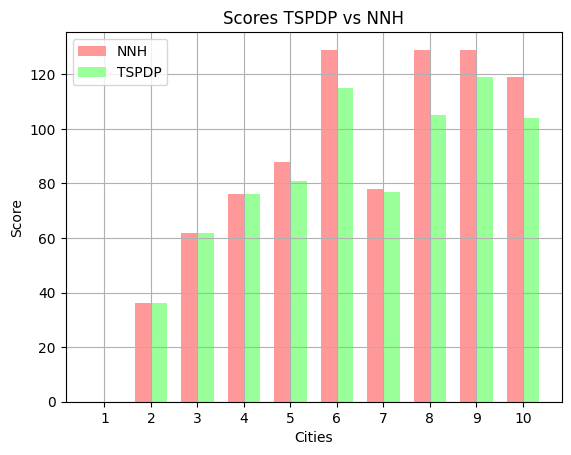

In [92]:
list1 = np.array([float(item) for item in scores1])
list2 = np.array([float(item) for item in scores2])

bar_width = 0.35  # Width of the bars
index = np.arange(len(N_cities))  # Index for the x-axis

plt.grid()
plt.bar(index, list1, bar_width, label='NNH', color="#FF9999")
plt.bar(index + bar_width, list2, bar_width, label='TSPDP', color="#99FF99")
plt.xlabel('Cities')
plt.ylabel('Score')
plt.title('Scores TSPDP vs NNH')
plt.xticks(index + bar_width / 2, N_cities)  # Centering x ticks
plt.legend()
plt.savefig("scores.png", transparent=True)
plt.show()

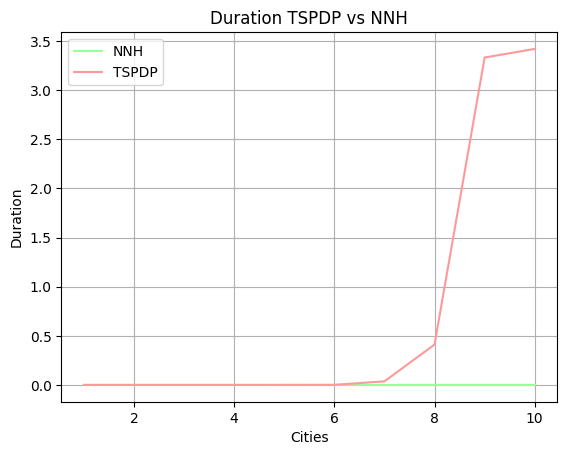

In [96]:
list1 = np.array([float(item) for item in duration1])
list2 = np.array([float(item) for item in duration2])

plt.grid()
plt.plot(N_cities, list1, label='NNH', color="#99FF99")
plt.plot(N_cities, list2, label='TSPDP', color="#FF9999")
plt.xlabel('Cities')
plt.ylabel('Duration')
plt.title('Duration TSPDP vs NNH')
plt.legend()
plt.savefig("duration.png", transparent=True)
plt.show()

In [104]:
%time
tours1 = []
scores1 = []
duration1 = []

tours2 = []
scores2 = []
duration2 = []
N_cities = []
start_city = 0

for i in tqdm(range(1, 12)):
  num_cities = i
  N_cities.append(num_cities)

  lower_triangle = np.random.randint(1, 20, size=(num_cities, num_cities))
  np.fill_diagonal(lower_triangle, 0)
  SM = lower_triangle + lower_triangle.T - np.diag(lower_triangle.diagonal())

  start = time.time()
  solver = TSPSolver(SM, start_city)
  solver.solve_tsp()
  end = time.time()

  tours1.append(solver.best_tour)
  scores1.append(solver.best_length)
  duration1.append('{:.6f}'.format(end - start))

  start = time.time()
  solver = TSPSolverWithThreads(SM, start_city)
  solver.solve_tsp()
  end = time.time()

  tours2.append(solver.best_tour)
  scores2.append(solver.best_length)
  duration2.append('{:.6f}'.format(end - start))

CPU times: user 0 ns, sys: 83 µs, total: 83 µs
Wall time: 161 µs


100%|██████████| 11/11 [00:51<00:00,  4.70s/it]


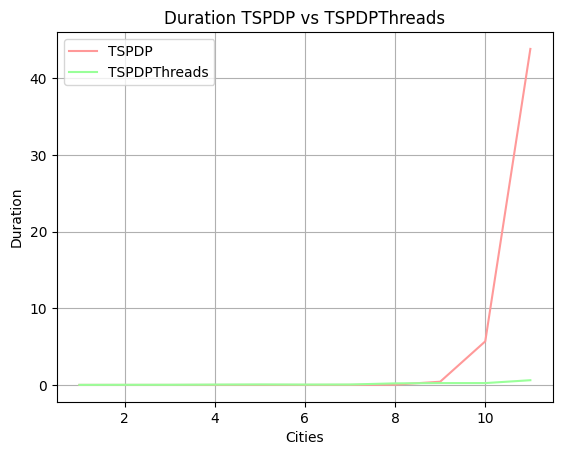

In [107]:
list1 = np.array([float(item) for item in duration1])
list2 = np.array([float(item) for item in duration2])

plt.grid()
plt.plot(N_cities, list1, label='TSPDP', color="#FF9999")
plt.plot(N_cities, list2, label='TSPDPThreads', color="#99FF99")
plt.xlabel('Cities')
plt.ylabel('Duration')
plt.title('Duration TSPDP vs TSPDPThreads')
plt.legend()
plt.savefig("durationThreads.png", transparent=True)
plt.show()

In [108]:
print(scores1)
print(scores2)

[0, 56, 47, 73, 101, 89, 78, 127, 99, 115, 132]
[0, 56, 47, 73, 101, 89, 78, 127, 114, 158, 139]
